In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unrar x '/content/drive/My Drive/dataset.rar' '/content/drive/My Drive/'

Streaming output truncated to the last 5000 lines.
Extracting  /content/drive/My Drive/dataset/training_set/cats/cat.3701.jpg      47%  OK 
Extracting  /content/drive/My Drive/dataset/training_set/cats/cat.3702.jpg      47%  OK 
Extracting  /content/drive/My Drive/dataset/training_set/cats/cat.3703.jpg      47%  OK 
Extracting  /content/drive/My Drive/dataset/training_set/cats/cat.3704.jpg      47%  OK 
Extracting  /content/drive/My Drive/dataset/training_set/cats/cat.3705.jpg      47%  OK 
Extracting  /content/drive/My Drive/dataset/training_set/cats/cat.3706.jpg      47%  OK 
Extracting  /content/drive/My Drive/dataset/training_set/cats/cat.3707.jpg      47%  OK 
Extracting  /content/drive/My Drive/dataset/training_set/cats/cat.3708.jpg      47%  OK 
Extracting  /content/drive/My Drive/dataset/training_set/cats/cat.3709.jpg      47%  OK 
Extracting  /content/drive/My Drive/dataset/training_set/cats/cat.3

In [6]:
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow . keras import Sequential
from tensorflow . keras . layers import Layer
from tensorflow . keras . layers import Dense,Dropout
from tensorflow . keras . layers import Conv2D
from tensorflow . keras . layers import MaxPool2D
from tensorflow . keras . models import Model
from keras.layers import Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import ReLU

In [3]:
%cd '/content/drive/My Drive/'

/content/drive/My Drive


In [4]:
# Part 2 - Fitting the CNN to the images

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('dataset/training_set',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('dataset/test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [7]:
x = Input( shape =( 64 , 64,3 ))
conv = Conv2D (32,(3,3),
               activation ='linear',
               kernel_initializer='glorot_uniform', padding='same')(x)
max_statistic = MaxPool2D ( (2,2),
                           padding ='valid')( conv )

In [8]:
range_statistic = tf. math . negative ( conv )
range_statistic = MaxPool2D ( (2,2),padding ='same')(range_statistic )
# negative of negative in step (1) to revert
range_statistic = tf. math . negative ( range_statistic )
range_statistic = tf. math . subtract ( max_statistic ,range_statistic )
concatted =tf. keras . layers . Concatenate () ([ max_statistic ,range_statistic ])

In [9]:
#second conv and range pooled layed
conv2 = Conv2D (32,(3,3),
               activation ='linear',
               kernel_initializer='glorot_uniform', padding='same')(concatted)
max_statistic2 = MaxPool2D ( (2,2),
                           padding ='valid')( conv2 )
range_statistic2 = tf. math . negative ( conv2 )
range_statistic2 = MaxPool2D ( (2,2),padding ='same')(range_statistic2 )
# negative of negative in step (1) to revert
range_statistic2 = tf. math . negative ( range_statistic2 )
range_statistic2 = tf. math . subtract ( max_statistic2 ,range_statistic2 )
concatted2 =tf. keras . layers . Concatenate () ([ max_statistic2 ,range_statistic2 ])

In [10]:
#3rdconv and range pooled layed
conv3 = Conv2D (32,(3,3),
               activation ='linear',
               kernel_initializer='glorot_uniform', padding='same')(concatted2)
max_statistic3 = MaxPool2D ( (2,2),
                           padding ='valid')( conv3 )
range_statistic3 = tf. math . negative ( conv3 )
range_statistic3 = MaxPool2D ( (2,2),padding ='same')(range_statistic3 )
# negative of negative in step (1) to revert
range_statistic3 = tf. math . negative ( range_statistic3 )
range_statistic3 = tf. math . subtract ( max_statistic3 ,range_statistic3 )
concatted3 =tf. keras . layers . Concatenate () ([ max_statistic3 ,range_statistic3 ])

In [11]:
features = Flatten ()( concatted3 )
features = ReLU ()( features )

In [12]:
dense = Dense ( units =256 ,activation ='relu')( features )
predictions = Dense ( units =1,activation ='sigmoid',name ='output')( dense )

In [13]:
model = Model ( inputs =x,outputs = predictions )

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
tf.math.negative (TFOpLambda)   (None, 64, 64, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 32)   0           tf.math.negative[0][0]           
______________________________________________________________________________________________

In [15]:
import tensorflow.keras.metrics
class F1_Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.precision_fn = tensorflow.keras.metrics.Precision(thresholds=0.5)
        self.recall_fn = tensorflow.keras.metrics.Recall(thresholds=0.5)

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        # since f1 is a variable, we use assign
        self.f1.assign(2 * ((p * r) / (p + r + 1e-6)))

    def result(self):
        return self.f1

    def reset_states(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_states()
        self.recall_fn.reset_states()
        self.f1.assign(0)

In [16]:
#from tensorflow.keras.optimizers import SGD
#opt = SGD(lr=0.001, momentum=0.9)
model . compile ( optimizer ='adam',
                 loss ='binary_crossentropy',
                 metrics =['accuracy',F1_Score()])

In [17]:
#Batch_size
bs=32

In [18]:
his=model.fit(training_set,
                         batch_size=bs,
                         steps_per_epoch=len(training_set)//bs,
                         epochs = 150,
                         validation_data = test_set,
                         validation_steps=len(test_set)//bs)

Epoch 1/150
7/7 [==============================] - ETA: 0s - loss: 0.7974 - accuracy: 0.5223 - f1_score: 0.6397

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric F1_Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


7/7 [==============================] - 76s 7s/step - loss: 0.7974 - accuracy: 0.5223 - f1_score: 0.6397 - val_loss: 0.6894 - val_accuracy: 0.5000 - val_f1_score: 0.6522
Epoch 2/150
7/7 [==============================] - 56s 8s/step - loss: 0.6957 - accuracy: 0.5982 - f1_score: 0.5714 - val_loss: 0.6682 - val_accuracy: 0.5625 - val_f1_score: 0.3636
Epoch 3/150
7/7 [==============================] - 50s 7s/step - loss: 0.6968 - accuracy: 0.5045 - f1_score: 0.5647 - val_loss: 0.6727 - val_accuracy: 0.6250 - val_f1_score: 0.7391
Epoch 4/150
7/7 [==============================] - 48s 7s/step - loss: 0.6808 - accuracy: 0.5714 - f1_score: 0.6522 - val_loss: 0.6742 - val_accuracy: 0.5312 - val_f1_score: 0.6809
Epoch 5/150
7/7 [==============================] - 47s 7s/step - loss: 0.6958 - accuracy: 0.5134 - f1_score: 0.5514 - val_loss: 0.6515 - val_accuracy: 0.6250 - val_f1_score: 0.0000e+00
Epoch 6/150
7/7 [==============================] - 44s 7s/step - loss: 0.6704 - accuracy: 0.5580 - f1_s

In [22]:
f1=his.history['val_f1_score']
sum(f1)/len(f1)

0.7145233891407649

In [23]:
f1=his.history['f1_score']
sum(f1)/len(f1)

0.7125723497072856

In [24]:
f1=his.history['val_accuracy']
sum(f1)/len(f1)

0.706875

In [25]:
f1=his.history['accuracy']
sum(f1)/len(f1)

0.71755952556928

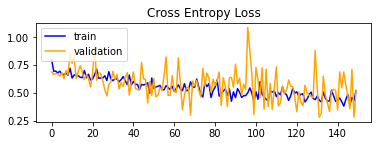

In [19]:
from matplotlib import pyplot
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(his.history['loss'], color='blue', label='train')
pyplot.plot(his.history['val_loss'], color='orange', label='test')
pyplot.legend(['train', 'validation'], loc='upper left')

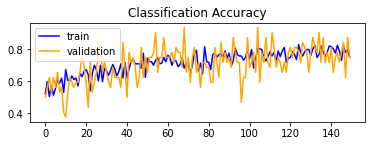

In [20]:
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(his.history['accuracy'], color='blue', label='train')
pyplot.plot(his.history['val_accuracy'], color='orange', label='test')
pyplot.legend(['train', 'validation'], loc='upper left')

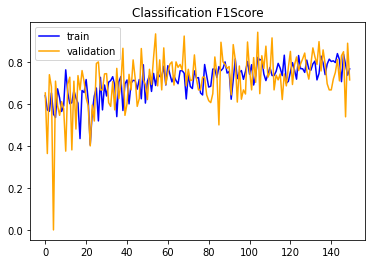

In [21]:
# plot accuracy
pyplot.subplot()
pyplot.title('Classification F1Score')
pyplot.plot(his.history['f1_score'], color='blue', label='train')
pyplot.plot(his.history['val_f1_score'], color='orange', label='test')
pyplot.legend(['train', 'validation'], loc='upper left')